In [48]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [20]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [44]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [30]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [5]:
f = pd.read_csv('/ocean/eolson/MEOPAR/obs/PSFCitSci/2016ChlorophyllChlData.csv')
g = pd.read_csv('/ocean/eolson/MEOPAR/obs/PSFCitSci/2016ChlorophyllStationData.csv')
g['DateCollected'] = g['DateCollected '].values
w = pd.merge(f, g, on = ['Station', 'DateCollected', 'Depth_m'])
cs_table = w[w.quality_flag != 4]

In [33]:
local = pytz.timezone ("America/Los_Angeles")

In [88]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_chl = np.array([])
list_of_model_chl = np.array([])
for n in cs_table.index:
    Yind, Xind = geo_tools.find_closest_model_point(cs_table.Longitude[n], 
                                                        cs_table.Latitude[n], 
                                                        X, Y, land_mask = bathy.mask)
    if mesh.variables['tmask'][0,4,Yind, Xind] == 1:
        if type(cs_table.TimeCollected[n]) != float:
            try:
                local_datetime = (datetime.datetime.combine(datetime.datetime.strptime(
                    cs_table.DateCollected[n], '%m/%d/%Y'),
                                                            datetime.datetime.strptime(
                                                               cs_table.TimeCollected[n], 
                                                               '%I:%M:%S %p').time()))
            except (ValueError):
                local_datetime = (datetime.datetime.combine(datetime.datetime.strptime(
                    cs_table.DateCollected[n], '%m-%d-%Y'),
                                                            datetime.datetime.strptime(
                                                               cs_table.TimeCollected[n], 
                                                               '%I:%M:%S %p').time()))
            date = local.localize(local_datetime, is_dst=True).astimezone(pytz.utc)
            sub_dir = date.strftime('%d%b%y').lower()
            datestr = date.strftime('%Y%m%d')
            fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
            nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
            if date.minute < 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                after = before + datetime.timedelta(hours=1)
                sub_dir2 = after.strftime('%d%b%y').lower()
                datestr2 = after.strftime('%Y%m%d')
                fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
                nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
                delta = (date.minute + 30) / 60
                chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                               + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                               + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                           (1- delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                               + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                               + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
            if date.minute >= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                after = before + datetime.timedelta(hours=1)
                sub_dir2 = after.strftime('%d%b%y').lower()
                datestr2 = after.strftime('%Y%m%d')
                fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
                nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
                delta = (date.minute + 30) / 60
                chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                               + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                               + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                           (1- delta)*(nuts.variables['diatoms'][after.hour, 1, Yind, Xind] 
                               + nuts.variables['ciliates'][after.hour,1,Yind, Xind] 
                               + nuts.variables['flagellates'][after.hour,1,Yind,Xind]))
            list_of_lons = np.append(list_of_lons, cs_table.Longitude[n])
            list_of_lats = np.append(list_of_lats, cs_table.Latitude[n])
            list_of_datetimes = np.append(list_of_datetimes, date)
            list_of_cs_chl = np.append(list_of_cs_chl, cs_table.Chla_ugL[n])
            list_of_model_chl = np.append(list_of_model_chl, chl_val)

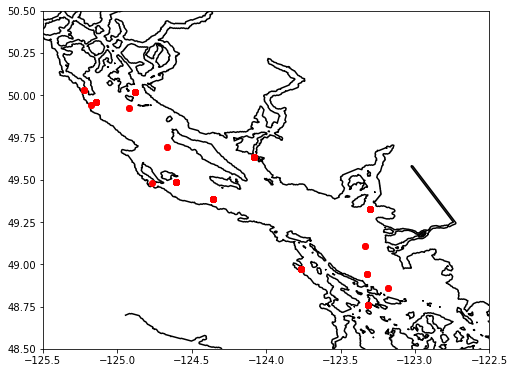

In [105]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 50.5)
ax.set_xlim(-125.5, -122.5);

In [89]:
list_of_cs_chl.shape

(193,)

bias =  -0.302185922221
RMSE = 5.92938317147
Willmott = 0.500199936027


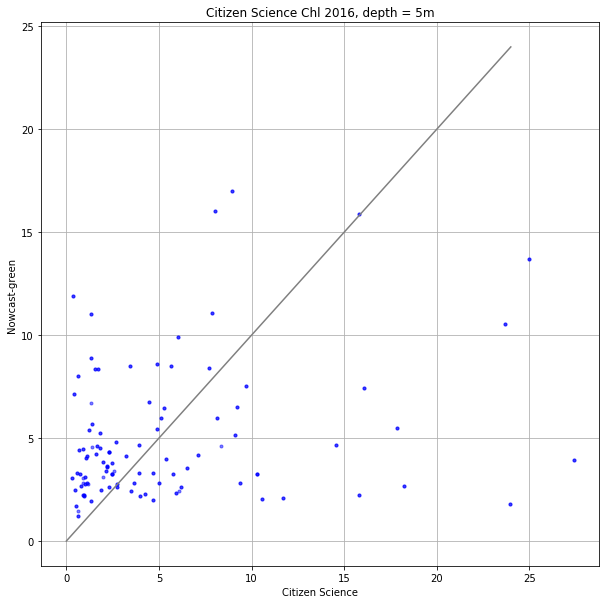

In [90]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_chl, list_of_model_chl,  'b.', alpha = 0.5)
ax.plot(np.arange(0,25), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Chl 2016, depth = 5m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(list_of_cs_chl) + np.mean(list_of_model_chl)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl - list_of_cs_chl)**2) /
                              len(list_of_cs_chl))))
xbar = np.mean(list_of_cs_chl)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl - list_of_cs_chl)**2)  / 
                             np.sum((np.abs(list_of_model_chl - xbar) 
                                     + np.abs(list_of_cs_chl - xbar))**2))))

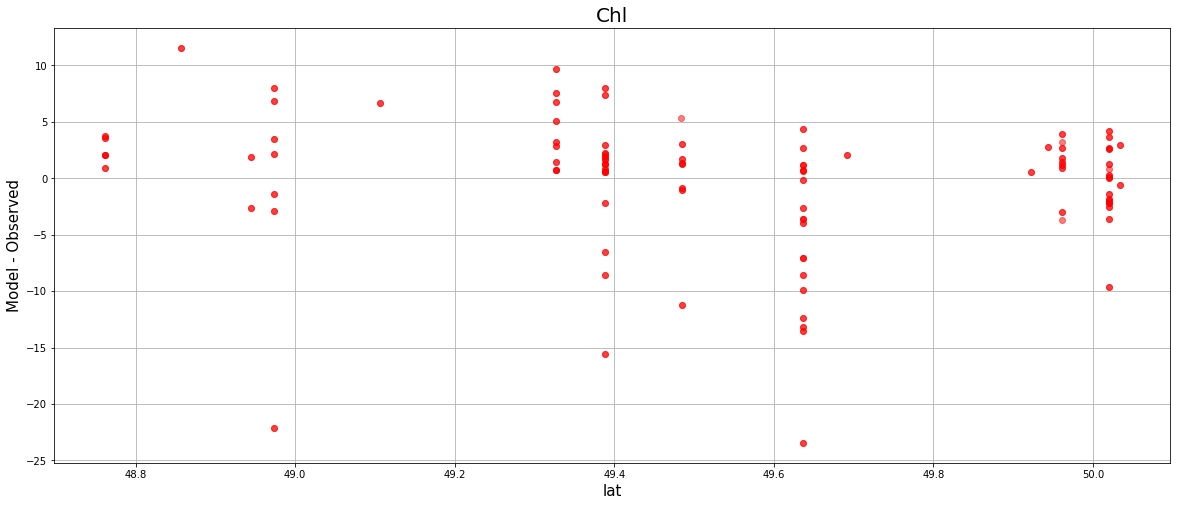

In [91]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20)

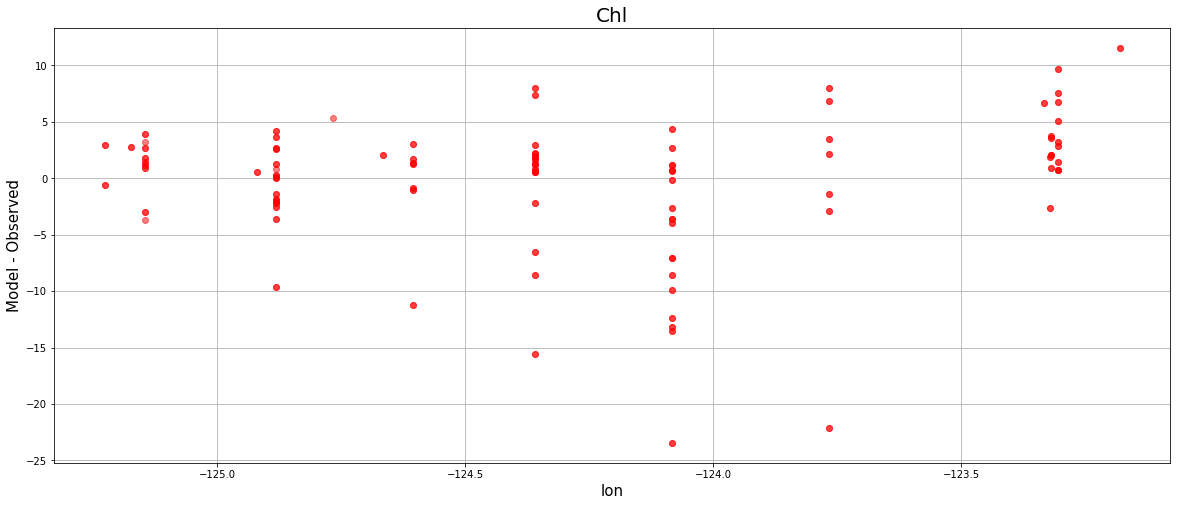

In [92]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20)

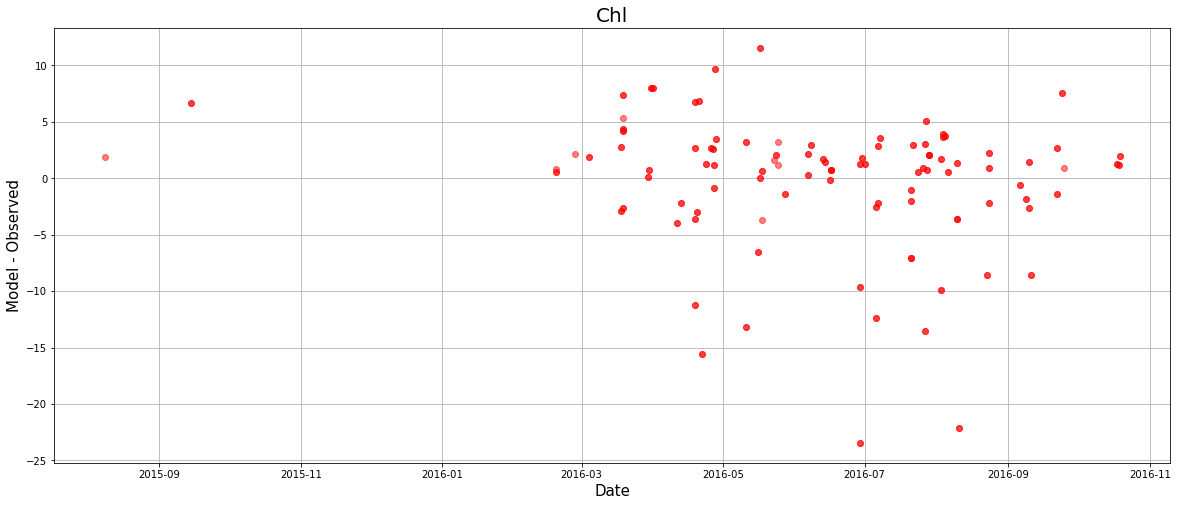

In [93]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20)

In [84]:
cs_table2 = cs_table[cs_table.quality_flag != 3]

In [97]:
list_of_lons2 = np.array([])
list_of_lats2 = np.array([])
list_of_datetimes2 = np.array([])
list_of_cs_chl2 = np.array([])
list_of_model_chl2 = np.array([])
for n in cs_table2.index:
    Yind, Xind = geo_tools.find_closest_model_point(cs_table2.Longitude[n], 
                                                        cs_table2.Latitude[n], 
                                                        X, Y, land_mask = bathy.mask)
    if mesh.variables['tmask'][0,4,Yind, Xind] == 1:
        if type(cs_table2.TimeCollected[n]) != float:
            try:
                local_datetime = (datetime.datetime.combine(datetime.datetime.strptime(
                    cs_table2.DateCollected[n], '%m/%d/%Y'),
                                                            datetime.datetime.strptime(
                                                               cs_table2.TimeCollected[n], 
                                                               '%I:%M:%S %p').time()))
            except (ValueError):
                local_datetime = (datetime.datetime.combine(datetime.datetime.strptime(
                    cs_table2.DateCollected[n], '%m-%d-%Y'),
                                                            datetime.datetime.strptime(
                                                               cs_table2.TimeCollected[n], 
                                                               '%I:%M:%S %p').time()))
            date = local.localize(local_datetime, is_dst=True).astimezone(pytz.utc)
            sub_dir = date.strftime('%d%b%y').lower()
            datestr = date.strftime('%Y%m%d')
            fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
            nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
            if date.minute < 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                after = before + datetime.timedelta(hours=1)
                sub_dir2 = after.strftime('%d%b%y').lower()
                datestr2 = after.strftime('%Y%m%d')
                fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
                nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
                delta = (date.minute + 30) / 60
                chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                               + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                               + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                           (1- delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                               + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                               + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
            if date.minute >= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                after = before + datetime.timedelta(hours=1)
                sub_dir2 = after.strftime('%d%b%y').lower()
                datestr2 = after.strftime('%Y%m%d')
                fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
                nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
                delta = (date.minute + 30) / 60
                chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                               + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                               + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                           (1- delta)*(nuts.variables['diatoms'][after.hour, 1, Yind, Xind] 
                               + nuts.variables['ciliates'][after.hour,1,Yind, Xind] 
                               + nuts.variables['flagellates'][after.hour,1,Yind,Xind]))
            list_of_lons2 = np.append(list_of_lons2, cs_table2.Longitude[n])
            list_of_lats2 = np.append(list_of_lats2, cs_table2.Latitude[n])
            list_of_datetimes2 = np.append(list_of_datetimes2, date)
            list_of_cs_chl2 = np.append(list_of_cs_chl2, cs_table2.Chla_ugL[n])
            list_of_model_chl2 = np.append(list_of_model_chl2, chl_val)

In [98]:
list_of_cs_chl2.shape

(141,)

bias =  -0.141669932584
RMSE = 5.92675122351
Willmott = 0.437868838129


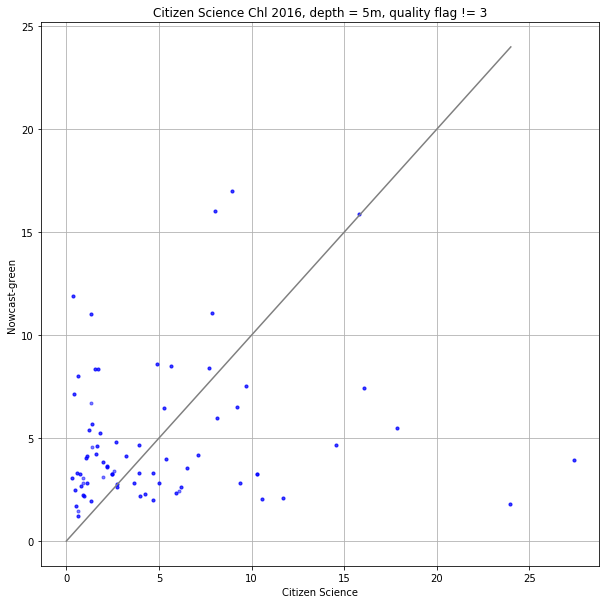

In [99]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_chl2, list_of_model_chl2,  'b.', alpha = 0.5)
ax.plot(np.arange(0,25), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Chl 2016, depth = 5m, quality flag != 3')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(list_of_cs_chl2) + np.mean(list_of_model_chl2)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl2 - list_of_cs_chl2)**2) /
                              len(list_of_cs_chl2))))
xbar = np.mean(list_of_cs_chl2)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl2 - list_of_cs_chl2)**2)  / 
                             np.sum((np.abs(list_of_model_chl2 - xbar) 
                                     + np.abs(list_of_cs_chl2 - xbar))**2))))